# Classification models training

Use this notebook to train classification models (KNN, SVM, etc) on leaf color classification.

## Data gathering

In [ ]:
# Use pre-annotated dataset with each leaf segmentation and class
# From the data.yaml of this dataset, the label number to corresponding class is:
# 0=dark, 1=dead, 2=light, 3=medium

# This creates a list called 'obj_data', which containg every object as a tuple...
# ...containing (obj_classnum, obj_crop)

import scg_detection_tools.utils.image_tools as imtools
import scg_detection_tools.utils.cvt as cvt
from scg_detection_tools.utils.file_handling import get_all_files_from_paths
from scg_detection_tools.dataset import read_dataset_annotation
from analyze import parse_seg_annotations
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_DIR = "/home/juliocesar/leaf-detection/imgs/light_group/images"
LBL_DIR = "/home/juliocesar/leaf-detection/imgs/light_group/labels"

#IMG_DIR = "/home/juliocesar/leaf-detection/imgs/hemacias/annotated/images"
#LBL_DIR = "/home/juliocesar/leaf-detection/imgs/hemacias/annotated/labels"

imgs = get_all_files_from_paths(IMG_DIR, skip_ext=[".txt", ".json", ".yaml"])
ann_files, img_ann_idx = parse_seg_annotations(imgs, LBL_DIR)

# Keep track of every object as (nclass, obj_crop)
obj_data = []

# CHOOSING 32x32 because of calculated average
STANDARD_SIZE = (32, 32)
MAX_MEDIUM = 300 # avoid making dataset unbalanced
curr_medium = 0

# !!!!!! taken from data.yaml
class_map = {0: "dark", 1: "dead", 2: "light", 3: "medium"}
#class_map = {0: "purple", 1: "white"}

for img in imgs:
    ann_file = ann_files[img_ann_idx[img]]
    annotations = read_dataset_annotation(ann_file, separate_class=False)

    # check if contours are boxes or segments
    orig = cv2.imread(img)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    imgsz = orig.shape[:2]

    for ann in annotations:
        nclass = ann[0]
        if nclass == 3:
            if curr_medium >= MAX_MEDIUM:
                continue
            else:
                curr_medium += 1

        contour = ann[1:]
        if len(contour) == 4:
            mask = cvt.boxes_to_masks([contour], imgsz=imgsz, normalized=True)[0]
        else:
            mask = cvt.contours_to_masks([contour], imgsz=imgsz, normalized=True)[0]
        
        # get only segmented object from image
        masked = orig.copy()
        masked[mask[:,:] < 255] = 0

        # crop a box around it
        points = np.array(contour).reshape(len(contour) // 2, 2)
        box = cvt.segment_to_box(points, normalized=True, imgsz=imgsz)
        obj_crop = imtools.crop_box_image(masked, box)

        # resize to 32x32 and add to our data
        obj_crop = cv2.resize(obj_crop, STANDARD_SIZE, cv2.INTER_CUBIC)
        obj_data.append((nclass, obj_crop))


ncls = [obj[0] for obj in obj_data]
for cls in np.unique(ncls):
    print(f"Samples of type {cls}: {class_map[cls]!r} = {len([c for c in ncls if c == cls])}")


In [2]:
# Split between Train and Test to evaluate model as well
from sklearn.model_selection import train_test_split

X = []
y = []
for nclass, obj_crop in obj_data:
    X.append(obj_crop)
    y.append(nclass)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
class_labels = [class_map[c] for c in class_map]

In [3]:
# Preprocessing functions (to be able to call clf.predict(imgs) instead of having to extract features first and then calling clf.predict(features))
# -> rn_feature_preprocess: use resnet feature extraction to train classificators
# -> channels_feature_preprocess: extract RGB, HSV and Gray values from a 32x32 image as features
def rn_feature_preprocess(objX):
    import numpy as np

    if not isinstance(objX[0], np.ndarray):
        raise TypeError("'objX' passed to preprocess function must be a list of np.ndarray RGB images")

    from analysis.classify import resnet_extract_features
    processed = []
    for obj in objX:
        processed.append(resnet_extract_features(obj))
    return processed


def channels_feature_preprocess(objX):
    import cv2
    import numpy as np

    if not isinstance(objX[0], np.ndarray):
        raise TypeError("'objX' passed to preprocess function must be a list of np.ndarray RGB images")

    processed = []
    for obj in objX:
        rgb = cv2.resize(obj, (32,32))
        hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

        attributes = np.concatenate((rgb.flatten(), hsv.flatten(), gray.flatten()))
        processed.append(attributes)

    return processed


## Parameters test training (e.g. optimal k value for KNN, loss for SGD)

In [ ]:
######################################################
############### K VALUE TEST FOR KNN #################
######################################################

################ CHANNELS FEATURE EXTRACTION
### LAST TESTED OPTIMAL K=4 (no nca)

from analysis.classify import KNNClassifier

MAX_K = 40
for k in range(1, MAX_K+1):
    knn = KNNClassifier(n_neighbors=k, enable_nca=False, preprocess=channels_feature_preprocess)
    knn.train(X_train, y_train)
    
    print("_"*82)
    print(f"EVALUATION: K = {k}")
    print("_"*82)
    knn.evaluate(X_test, y_test, disp_labels=class_labels)


In [ ]:
################ RESNET18 FEATURE EXTRACTION
### LAST TESTED OPTIMAL K=8 AND K=19

from analysis.classify import KNNClassifier

MAX_K = 40
for k in range(1, MAX_K+1):
    knn = KNNClassifier(n_neighbors=k, preprocess=rn_feature_preprocess, enable_nca=False)
    knn.train(X_train, y_train)
    
    print("_"*82)
    print(f"EVALUATION: K = {k}")
    print("_"*82)
    knn.evaluate(X_test, y_test, disp_labels=class_labels)

In [ ]:
######################################################
################# LOSS TEST FOR SGD ##################
######################################################

######### CHANNELS FEATURE EXTRACTION
# BEST TEST: LOG_LOSS

from analysis.classify import SGDBasedClassifier

LOSS_FN = ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]
for loss in LOSS_FN:
    sgd = SGDBasedClassifier(loss=loss, max_iter=1000, preprocess=channels_feature_preprocess)
    sgd.train(X_train, y_train)

    print("_"*82)
    print(f"EVALUATION: loss = {loss!r}")
    print("_"*82)
    sgd.evaluate(X_test, y_test, disp_labels=class_labels)


In [ ]:
######### RESNET18 FEATURE EXTRACTION
# BEST TEST: HINGE

from analysis.classify import SGDBasedClassifier

LOSS_FN = ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]
for loss in LOSS_FN:
    sgd = SGDBasedClassifier(loss=loss, max_iter=1000, preprocess=rn_feature_preprocess)
    sgd.train(X_train, y_train)

    print("_"*82)
    print(f"EVALUATION: loss = {loss!r}")
    print("_"*82)
    sgd.evaluate(X_test, y_test, disp_labels=class_labels)

## Actual training

In [ ]:
#####################################################
##### TRAIN KNN WITH RESNET FEATURE EXTRACTION #####
#####################################################

from analysis.classify import KNNClassifier

# LEAF CLASSIFICATION: K = 8
# BLOOD CELL CLASSIFICATION: K = 2

resnet_knn = KNNClassifier(n_neighbors=8, preprocess=rn_feature_preprocess)
resnet_knn.train(X_train, y_train)
resnet_knn.evaluate(X_test, y_test, disp_labels=class_labels)

In [6]:
resnet_knn.save_state("knn_rn18_k8.skl")

In [ ]:
#############################################################
##### TRAIN KNN WITH MANUAL CHANNELS FEATURE EXTRACTION #####
#############################################################

from analysis.classify import KNNClassifier

# LEAF CLASSIFICATION: K = 4
# BCELL CLASSIFICATION: K = 5

knn = KNNClassifier(n_neighbors=4, preprocess=channels_feature_preprocess)
knn.train(X_train, y_train)
knn.evaluate(X_test, y_test, disp_labels=class_labels)

In [5]:
knn.save_state("knn_k4.skl")

In [ ]:
####################################################
##### TRAIN SVM WITH RESNET FEATURE EXTRACTION #####
####################################################

from analysis.classify import SVMClassifier

sv = SVMClassifier(preprocess=rn_feature_preprocess)
sv.train(X_train, y_train)
sv.evaluate(X_test, y_test, disp_labels=class_labels)

In [8]:
sv.save_state("svm_rn18.skl")

In [ ]:
############################################################
##### TRAIN SVM WITH MANUAL CHANNEL FEATURE EXTRACTION #####
############################################################

from analysis.classify import SVMClassifier

sv = SVMClassifier(preprocess=channels_feature_preprocess)
sv.train(X_train, y_train)
sv.evaluate(X_test, y_test, disp_labels=class_labels)

In [15]:
sv.save_state("svm.skl")

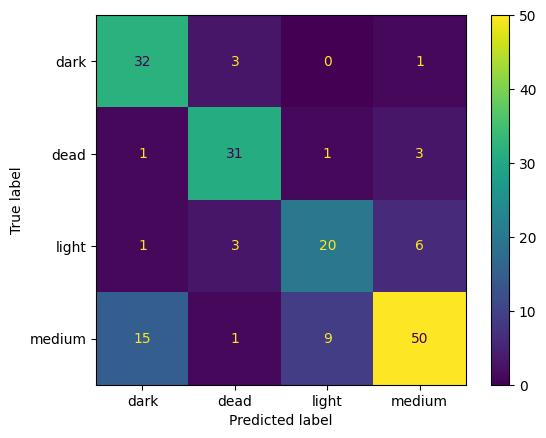

              precision    recall  f1-score   support

        dark       0.65      0.89      0.75        36
        dead       0.82      0.86      0.84        36
       light       0.67      0.67      0.67        30
      medium       0.83      0.67      0.74        75

    accuracy                           0.75       177
   macro avg       0.74      0.77      0.75       177
weighted avg       0.76      0.75      0.75       177



In [22]:
############################################################
##### TRAIN SGD WITH MANUAL CHANNEL FEATURE EXTRACTION #####
############################################################

from analysis.classify import SGDBasedClassifier

sgd = SGDBasedClassifier(loss="hinge", preprocess=channels_feature_preprocess, max_iter=5000)
sgd.train(X_train, y_train)
sgd.evaluate(X_test, y_test, disp_labels=class_labels)

In [23]:
sgd.save_state("sgd.skl")

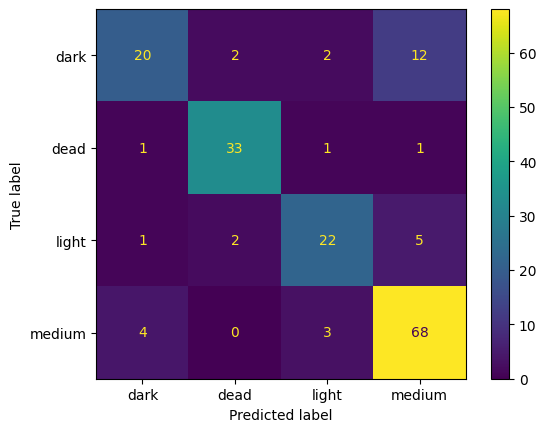

              precision    recall  f1-score   support

        dark       0.77      0.56      0.65        36
        dead       0.89      0.92      0.90        36
       light       0.79      0.73      0.76        30
      medium       0.79      0.91      0.84        75

    accuracy                           0.81       177
   macro avg       0.81      0.78      0.79       177
weighted avg       0.81      0.81      0.80       177



In [30]:
######################################################
##### TRAIN SGD WITH RESNET18 FEATURE EXTRACTION #####
######################################################

from analysis.classify import SGDBasedClassifier

sgd = SGDBasedClassifier(loss="hinge", preprocess=rn_feature_preprocess, max_iter=1000)
sgd.train(X_train, y_train)
sgd.evaluate(X_test, y_test, disp_labels=class_labels)

In [31]:
sgd.save_state("sgd_rn18.skl")

In [ ]:
###############################################################################################################
## CELLS BELOW ARE FOR CHECKING SAVED MODELS

In [ ]:
from analysis.classify import KNNClassifier

knn = KNNClassifier.from_state("/home/juliocesar/leaf-detection/checkpoints/classifiers/knn_k4.skl")
knn.evaluate(X_test, y_test, disp_labels=class_labels)

In [ ]:
from analysis.classify import SVMClassifier

svm = SVMClassifier.from_state("/home/juliocesar/leaf-detection/checkpoints/classifiers/svm.skl")
svm.evaluate(X_test, y_test, disp_labels=class_labels)

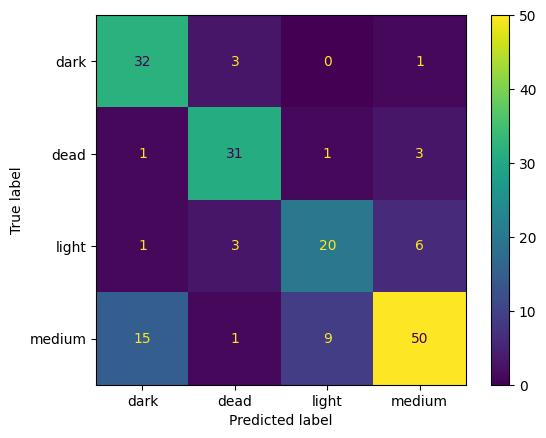

              precision    recall  f1-score   support

        dark       0.65      0.89      0.75        36
        dead       0.82      0.86      0.84        36
       light       0.67      0.67      0.67        30
      medium       0.83      0.67      0.74        75

    accuracy                           0.75       177
   macro avg       0.74      0.77      0.75       177
weighted avg       0.76      0.75      0.75       177



In [32]:
from analysis.classify import SGDBasedClassifier

sgd = SGDBasedClassifier.from_state("/home/juliocesar/leaf-detection/checkpoints/classifiers/sgd.skl")
sgd.evaluate(X_test, y_test, disp_labels=class_labels)